In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
project_path = '/content/drive/MyDrive/YOLO_Traffic_Signs'
os.makedirs(project_path, exist_ok=True)
%cd {project_path}

Mounted at /content/drive
/content/drive/MyDrive/YOLO_Traffic_Signs


In [2]:
!pip install ultralytics
!pip install roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
Setup complete ✅ (12 CPUs, 167.1 GB RAM, 39.9/235.7 GB disk)


In [3]:
!rm -rf /content/yolo_traffic_dataset
!rm -rf /content/traffic_detection

import kagglehub
path = kagglehub.dataset_download("andrewmvd/road-sign-detection")
print("Dataset path:", path)

import xml.etree.ElementTree as ET
from pathlib import Path
import shutil
import cv2
import random

def convert_dataset():
    base = "/content/yolo_dataset"
    for split in ['train', 'val']:
        os.makedirs(f"{base}/{split}/images", exist_ok=True)
        os.makedirs(f"{base}/{split}/labels", exist_ok=True)

    class_names = ['trafficlight', 'stop', 'speedlimit', 'crosswalk']
    xml_files = list(Path(f"{path}/annotations").glob("*.xml"))
    print(f"Toplam {len(xml_files)} annotation bulundu")
    random.shuffle(xml_files)
    split_idx = int(len(xml_files) * 0.8)
    processed = 0

    for i, xml_file in enumerate(xml_files):
        split = 'train' if i < split_idx else 'val'
        img_name = xml_file.stem + '.png'
        img_path = Path(f"{path}/images/{img_name}")

        if not img_path.exists():
            continue

        img = cv2.imread(str(img_path))
        if img is None:
            continue

        h, w = img.shape[:2]

        try:
            tree = ET.parse(xml_file)
            root = tree.getroot()

            # YOLO formatında labels
            labels = []

            for obj in root.findall('object'):
                name = obj.find('name').text.lower()

                # Sınıf ID'sini bul (basit mapping)
                if 'traffic' in name or 'light' in name:
                    class_id = 0
                elif 'stop' in name:
                    class_id = 1
                elif 'speed' in name or 'limit' in name:
                    class_id = 2
                elif 'cross' in name or 'walk' in name:
                    class_id = 3
                else:
                    class_id = 0  # default

                bbox = obj.find('bndbox')
                xmin = float(bbox.find('xmin').text)
                ymin = float(bbox.find('ymin').text)
                xmax = float(bbox.find('xmax').text)
                ymax = float(bbox.find('ymax').text)

                # YOLO format (normalized)
                x_center = (xmin + xmax) / 2 / w
                y_center = (ymin + ymax) / 2 / h
                width = (xmax - xmin) / w
                height = (ymax - ymin) / h

                if all(0 <= v <= 1 for v in [x_center, y_center, width, height]):
                    labels.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

            if labels:
                shutil.copy(img_path, f"{base}/{split}/images/{img_name}")
                label_path = f"{base}/{split}/labels/{xml_file.stem}.txt"
                with open(label_path, 'w') as f:
                    f.write('\n'.join(labels))

                processed += 1

        except Exception as e:
            print(f"Hata: {xml_file.name} - {e}")
            continue

    print(f"\n {processed} dosya işlendi.")
    return base

# Dataset'i dönüştür
dataset_path = convert_dataset()

100%|██████████| 218M/218M [00:11<00:00, 19.7MB/s]

Extracting files...


Dataset path: /root/.cache/kagglehub/datasets/andrewmvd/road-sign-detection/versions/1
Toplam 877 annotation bulundu

 877 dosya işlendi.


In [4]:
def verify_dataset(dataset_path):
    for split in ['train', 'val']:
        img_dir = f"{dataset_path}/{split}/images"
        lbl_dir = f"{dataset_path}/{split}/labels"
        images = os.listdir(img_dir)
        labels = os.listdir(lbl_dir)
        print(f"\n{split.upper()}:")
        print(f"  Images: {len(images)}")
        print(f"  Labels: {len(labels)}")

        if labels:
            with open(f"{lbl_dir}/{labels[0]}", 'r') as f:
                content = f.read()
                print(f"  Örnek label: {labels[0]}")
                print(f"  İçerik: {content[:100]}")

verify_dataset(dataset_path)


TRAIN:
  Images: 701
  Labels: 701
  Örnek label: road39.txt
  İçerik: 0 0.479687 0.468750 0.403125 0.892500

VAL:
  Images: 176
  Labels: 176
  Örnek label: road595.txt
  İçerik: 2 0.463333 0.413750 0.093333 0.067500


In [5]:
import yaml
data = {
    'path': dataset_path,
    'train': 'train/images',
    'val': 'val/images',
    'nc': 4,
    'names': ['traffic_light', 'stop_sign', 'speed_limit', 'crosswalk']
}

with open('data.yaml', 'w') as f:
    yaml.dump(data, f)

print("data.yaml oluşturuldu")

data.yaml oluşturuldu


In [6]:
from ultralytics import YOLO

!rm -rf /root/.cache/ultralytics

model = YOLO('yolov8n.pt')

results = model.train(
    data='data.yaml',
    epochs=25,
    imgsz=640,
    batch=16,
    device=0,
    project='traffic_v2',
    name='run1',
    patience=5,
    verbose=True  # Detaylı log
)

print("\n Eğitim tamamlandı.")

Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=run12, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=5, perspective=0.0, plots=True, pose=12.0, pretra

In [7]:
from datetime import datetime
import shutil
import os

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
project_folder = f"YOLO_Traffic_{timestamp}"

drive_path = f"/content/drive/MyDrive/{project_folder}"
os.makedirs(drive_path, exist_ok=True)

print(f"Klasör: {project_folder}")

Klasör: YOLO_Traffic_20251027_085054


In [8]:
source_path = "/content/drive/MyDrive/YOLO_Traffic_Signs/traffic_v2/run1"

if os.path.exists(source_path):
    shutil.copytree(source_path, f"{drive_path}/training_results")
    print("Eğitim sonuçları kaydedildi")

    important_files = [
        "weights/best.pt",
        "weights/last.pt",
        "results.png",
        "confusion_matrix.png",
        "results.csv"
    ]

    print("\nKaydedilen önemli dosyalar:")
    for file in important_files:
        file_path = f"{drive_path}/training_results/{file}"
        if os.path.exists(file_path):
            size = os.path.getsize(file_path) / (1024*1024)  # MB
            print(f"  ✓ {file} ({size:.2f} MB)")
else:
    print("Eğitim klasörü bulunamadı.")

Eğitim sonuçları kaydedildi

Kaydedilen önemli dosyalar:
  ✓ weights/best.pt (5.94 MB)
  ✓ weights/last.pt (5.94 MB)
  ✓ results.png (0.28 MB)
  ✓ confusion_matrix.png (0.14 MB)
  ✓ results.csv (0.00 MB)


In [9]:
from ultralytics import YOLO
import cv2
import numpy as np

model_path = f"{drive_path}/training_results/weights/best.pt"
model = YOLO(model_path)

print(f"Model yüklendi: {model_path}")

Model yüklendi: /content/drive/MyDrive/YOLO_Traffic_20251027_085054/training_results/weights/best.pt


In [10]:
results = model.val()
print("\n📈 MODEL PERFORMANSI:")
print("-" * 40)
print(f"mAP50:        {results.box.map50:.3f}")
print(f"mAP50-95:     {results.box.map:.3f}")
print(f"Precision:    {results.box.mp:.3f}")
print(f"Recall:       {results.box.mr:.3f}")
print("-" * 40)

Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2615.1±959.2 MB/s, size: 235.0 KB)
val: Scanning /content/yolo_dataset/val/labels.cache... 176 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 176/176 319.2Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 11/11 5.7it/s 1.9s
                   all        176        249      0.975      0.957      0.957      0.819
         traffic_light         19         29      0.928      0.886      0.874      0.655
             stop_sign         20         20       0.98          1      0.995      0.943
           speed_limit        137        160      0.994          1      0.995       0.91
             crosswalk         34         40          1      0.941      0.964      0.769
Speed: 1.4ms preprocess, 3.1ms 

In [11]:
!wget -q -O test_image.jpg "https://images.unsplash.com/photo-1558618666-fcd25c85cd64?w=640"

results = model("test_image.jpg")

for r in results:
    annotated_img = r.plot()
    cv2.imwrite(f"{drive_path}/test_result.jpg", annotated_img)

    print("\nTespit Edilenler:")
    if r.boxes:
        for box in r.boxes:
            class_id = int(box.cls)
            confidence = float(box.conf)
            print(f"  • {model.names[class_id]}: %{confidence*100:.1f}")
    else:
        print("Hiçbir şey tespit edilmedi")

print(f"\nTest sonucu kaydedildi: {drive_path}/test_result.jpg")


image 1/1 /content/drive/MyDrive/YOLO_Traffic_Signs/test_image.jpg: 448x640 2 traffic_lights, 99.1ms
Speed: 1.5ms preprocess, 99.1ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

Tespit Edilenler:
  • traffic_light: %76.7
  • traffic_light: %74.3

Test sonucu kaydedildi: /content/drive/MyDrive/YOLO_Traffic_20251027_085054/test_result.jpg


In [12]:
from ultralytics import YOLO
import json
from datetime import datetime
import os

model_path = f"{drive_path}/training_results/weights/best.pt"
model = YOLO(model_path)

val_results = model.val()

summary = {
    "tarih": datetime.now().strftime("%Y-%m-%d %H:%M"),
    "model": "YOLOv8n",
    "dataset": "Traffic Signs",
    "epochs": 25,
    "performans": {
        "mAP50": float(val_results.box.map50) if hasattr(val_results.box, 'map50') else 0.0,
        "mAP50-95": float(val_results.box.map) if hasattr(val_results.box, 'map') else 0.0,
        "precision": float(val_results.box.mp) if hasattr(val_results.box, 'mp') else 0.0,
        "recall": float(val_results.box.mr) if hasattr(val_results.box, 'mr') else 0.0
    },
    "model_boyutu_mb": os.path.getsize(model_path) / (1024*1024),
    "drive_klasoru": project_folder
}

with open(f"{drive_path}/summary.json", "w") as f:
    json.dump(summary, f, indent=4, ensure_ascii=False)

print("\n📋 PROJE ÖZETİ:")
print("-" * 40)
for key, value in summary.items():
    if isinstance(value, dict):
        print(f"{key}:")
        for k, v in value.items():
            if isinstance(v, float):
                print(f"  {k}: {v:.3f}")
            else:
                print(f"  {k}: {v}")
    elif isinstance(value, float):
        print(f"{key}: {value:.2f} MB")
    else:
        print(f"{key}: {value}")
print("-" * 40)

Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3347.8±783.7 MB/s, size: 231.3 KB)
val: Scanning /content/yolo_dataset/val/labels.cache... 176 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 176/176 363.8Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 11/11 5.5it/s 2.0s
                   all        176        249      0.975      0.957      0.957      0.819
         traffic_light         19         29      0.928      0.886      0.874      0.655
             stop_sign         20         20       0.98          1      0.995      0.943
           speed_limit        137        160      0.994          1      0.995       0.91
             crosswalk         34         40          1      0.941      0.964      0.769
Speed: 1.6ms preprocess, 1.2ms 

In [13]:
print("\nGOOGLE DRIVE'A KAYDEDİLENLER:")
print(f"Klasör: /My Drive/{project_folder}")
print("\nİçerik:")

for root, dirs, files in os.walk(drive_path):
    level = root.replace(drive_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')

    important_extensions = ['.pt', '.png', '.json', '.csv', '.jpg']
    subindent = ' ' * 2 * (level + 1)
    for file in files[:10]:  # İlk 10 dosya
        if any(file.endswith(ext) for ext in important_extensions):
            size = os.path.getsize(os.path.join(root, file)) / 1024
            print(f'{subindent}{file} ({size:.1f} KB)')

print("\nTÜM VERİLER KAYDEDİLDİ")
print(f"Drive konumu: /My Drive/{project_folder}")


GOOGLE DRIVE'A KAYDEDİLENLER:
Klasör: /My Drive/YOLO_Traffic_20251027_085054

İçerik:
YOLO_Traffic_20251027_085054/
  test_result.jpg (63.0 KB)
  summary.json (0.4 KB)
  training_results/
    labels.jpg (153.8 KB)
    train_batch0.jpg (506.1 KB)
    train_batch1.jpg (448.3 KB)
    train_batch2.jpg (467.6 KB)
    train_batch660.jpg (394.4 KB)
    train_batch661.jpg (385.7 KB)
    train_batch662.jpg (334.6 KB)
    val_batch0_labels.jpg (434.3 KB)
    val_batch0_pred.jpg (451.1 KB)
    weights/
      best.pt (6087.5 KB)
      last.pt (6087.5 KB)

TÜM VERİLER KAYDEDİLDİ
Drive konumu: /My Drive/YOLO_Traffic_20251027_085054


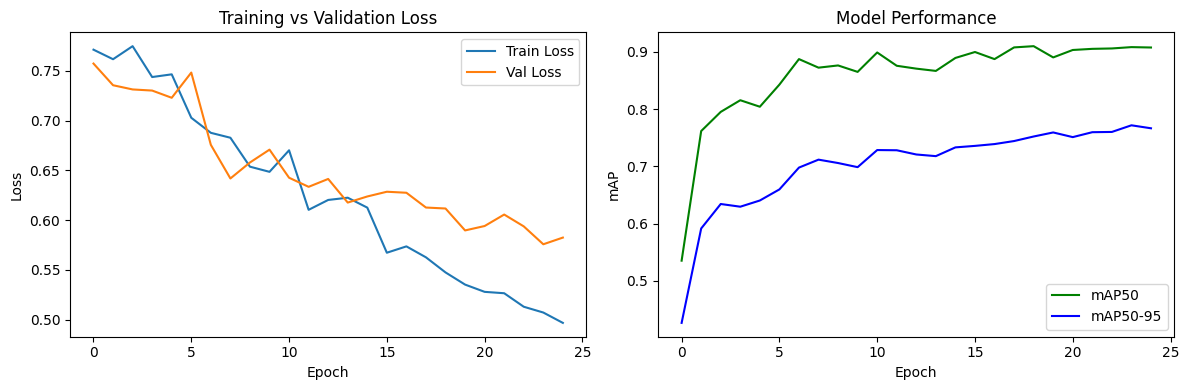

Grafikler kaydedildi: /content/drive/MyDrive/YOLO_Traffic_20251025_190015/training_results/training_graphs.png


In [14]:
import os
import pandas as pd
import matplotlib.pyplot as plt

csv_path = "/content/drive/MyDrive/YOLO_Traffic_20251025_190015/training_results/results.csv"
drive_path = os.path.dirname(csv_path)  # aynı klasöre kaydetmek için

if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.strip()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Loss grafiği
    if 'train/box_loss' in df.columns:
        ax1.plot(df.index, df['train/box_loss'], label='Train Loss')
    if 'val/box_loss' in df.columns:
        ax1.plot(df.index, df['val/box_loss'], label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training vs Validation Loss')
    ax1.legend()

    if 'metrics/mAP50(B)' in df.columns:
        ax2.plot(df.index, df['metrics/mAP50(B)'], label='mAP50', color='green')
    if 'metrics/mAP50-95(B)' in df.columns:
        ax2.plot(df.index, df['metrics/mAP50-95(B)'], label='mAP50-95', color='blue')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('mAP')
    ax2.set_title('Model Performance')
    ax2.legend()

    plt.tight_layout()
    save_path = os.path.join(drive_path, "training_graphs.png")
    plt.savefig(save_path)
    plt.show()

    print(f"Grafikler kaydedildi: {save_path}")
else:
    print("CSV dosyası bulunamadı.")
